In [1]:
#  !pip install pandas numpy matplotlib seaborn scikit-learn imbalanced-learn xgboost shap tensorflow==2.* joblib


In [2]:
# !pip install imblearn

# Data Handling

In [3]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# sklearn & imblearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (roc_auc_score, average_precision_score, precision_recall_curve,
                             roc_curve, classification_report, confusion_matrix)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.inspection import permutation_importance
from sklearn.utils import class_weight

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Try importing XGBoost and TensorFlow
try:
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
except Exception:
    XGBOOST_AVAILABLE = False

try:
    import tensorflow as tf
    from tensorflow.keras import layers, models, callbacks
    from sklearn.utils.class_weight import compute_class_weight
    TF_AVAILABLE = True
except Exception:
    TF_AVAILABLE = False

import joblib

# For SHAP (optional)
try:
    import shap
    SHAP_AVAILABLE = True
except Exception:
    SHAP_AVAILABLE = False

In [4]:
# Suppressing warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Setting a consistent style for plots
sns.set_theme(style="whitegrid")

In [5]:
df = pd.read_csv("dataset_fraud_detection_larger_run_1.csv")

In [6]:
df.head()

,transaction_id,user_id,account_age_days,total_orders,avg_order_value,past_fraud_flag,device_type,os,ip_region,billing_address_region,...,promo_code_used,refund_requests,order_timestamp,order_hour,order_day_of_week,orders_last_24h,high_value_flag,ip_shared_flag,chargeback_flag,fraudulent
0,TXN_978033343340,USR_73196,1902,4986,58.24,0,tablet,MacOS,Abuja,Abuja,...,1,3,2025-01-05 19:40:03,13,Sunday,10,1,1,1,0
1,TXN_813582749922,USR_11955,567,926,83.28,1,mobile,MacOS,Lagos,Port Harcourt,...,1,8,2025-07-07 07:49:38,23,Thursday,5,1,1,1,0
2,TXN_113318065960,USR_20396,1958,4802,99.65,1,desktop,MacOS,Kano,Ibadan,...,0,7,2025-01-05 16:23:56,23,Wednesday,10,1,1,1,0
3,TXN_573290209102,USR_31492,1784,4986,54.05,0,desktop,MacOS,Ibadan,Abuja,...,1,6,2025-04-14 05:24:11,23,Sunday,4,1,0,1,1
4,TXN_659386555738,USR_29665,1958,46,99.65,0,mobile,Android,Ibadan,Lagos,...,0,8,2025-01-21 12:47:49,11,Sunday,6,1,0,1,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   transaction_id           20000 non-null  object 
 1   user_id                  20000 non-null  object 
 2   account_age_days         20000 non-null  int64  
 3   total_orders             20000 non-null  int64  
 4   avg_order_value          20000 non-null  float64
 5   past_fraud_flag          20000 non-null  int64  
 6   device_type              20000 non-null  object 
 7   os                       20000 non-null  object 
 8   ip_region                20000 non-null  object 
 9   billing_address_region   20000 non-null  object 
 10  delivery_address_region  20000 non-null  object 
 11  billing_delivery_match   20000 non-null  int64  
 12  restaurant_region        20000 non-null  object 
 13  delivery_distance_km     20000 non-null  float64
 14  order_value           

In [8]:
df['fraudulent'].value_counts()

fraudulent
0    17074
1     2926
Name: count, dtype: int64

In [9]:
df.isnull().sum()

transaction_id                0
user_id                       0
account_age_days              0
total_orders                  0
avg_order_value               0
past_fraud_flag               0
device_type                   0
os                            0
ip_region                     0
billing_address_region        0
delivery_address_region       0
billing_delivery_match        0
restaurant_region             0
delivery_distance_km          0
order_value                   0
payment_method                0
card_type                  3567
payment_retries               0
promo_code_used               0
refund_requests               0
order_timestamp               0
order_hour                    0
order_day_of_week             0
orders_last_24h               0
high_value_flag               0
ip_shared_flag                0
chargeback_flag               0
fraudulent                    0
dtype: int64

In [10]:
df["fraudulent"].value_counts()

fraudulent
0    17074
1     2926
Name: count, dtype: int64

In [11]:
# The percentage of non-fraudulent data
(df["fraudulent"].value_counts()[1] / df.shape[0]) * 100

np.float64(14.63)

In [12]:
fraud_rate = df["fraudulent"].mean() * 100
print(f"Fraud Rate: {fraud_rate:.2f}%")

Fraud Rate: 14.63%


In [13]:
df["card_type"] = df["card_type"].fillna("Unknown")
df["card_type"].value_counts()

card_type
Verve         6618
Visa          4732
Unknown       3567
Amex          3073
Mastercard    2010
Name: count, dtype: int64

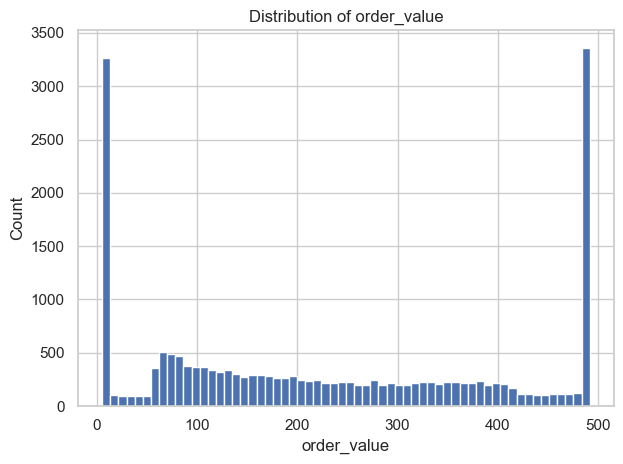

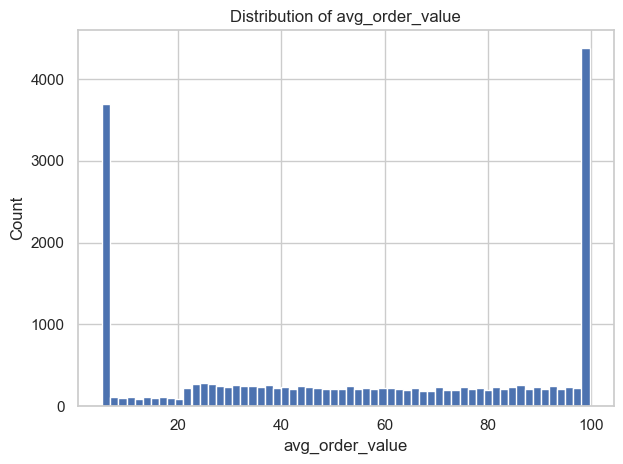

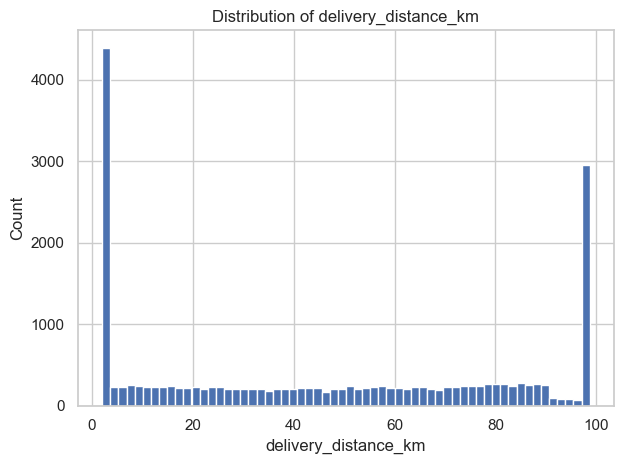

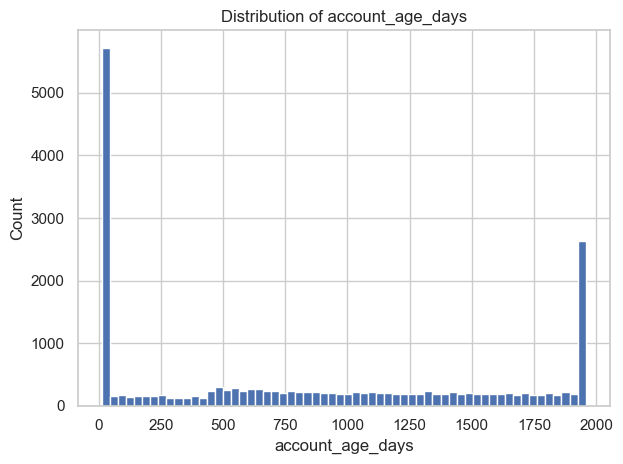

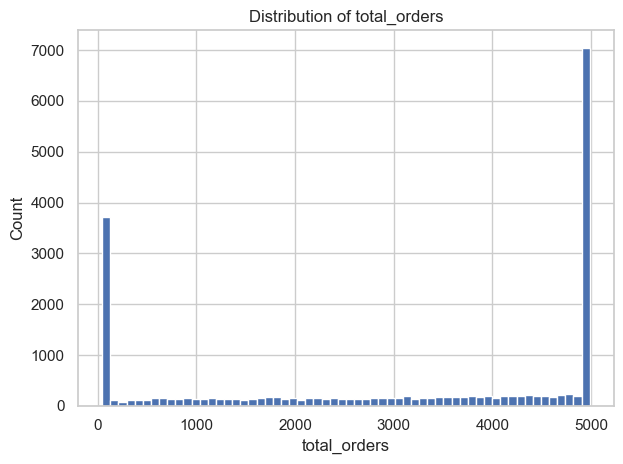

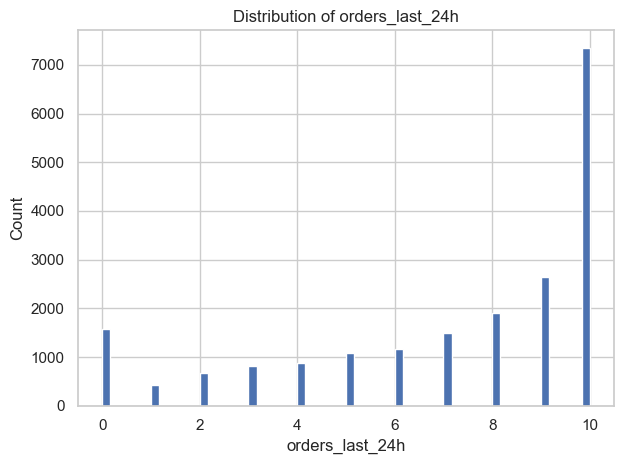

In [14]:
# Univariate Analysis of Numerical Features
numerical_features = ['order_value', 'avg_order_value', 'delivery_distance_km', 'account_age_days', 'total_orders', 'orders_last_24h']

for col in numerical_features:
    plt.figure()
    plt.hist(df[col], bins=60)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

Text(0, 0.5, 'Frequency')

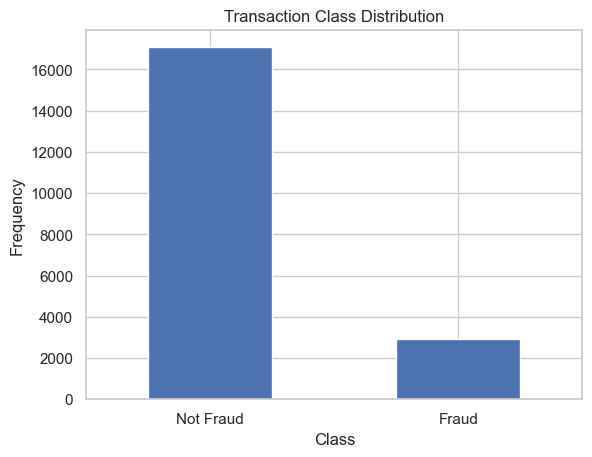

In [15]:
Labels = ["Not Fraud", "Fraud"]

count_classes = pd.value_counts(df['fraudulent'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction Class Distribution")
plt.xticks(range(2), Labels)
plt.xlabel("Class")
plt.ylabel("Frequency")


In [16]:
# Separating the fraudulent and non-fraudulent transactions
fraud = df[df['fraudulent'] == 1]
not_fraud = df[df['fraudulent'] == 0]

In [17]:
# Basic statistical summary for numerical features for individual classes
fraud.describe().T

,count,mean,std,min,25%,50%,75%,max
account_age_days,2926.0,852.041353,730.316398,13.00,13.0000,744.000,1549.5000,1958.00
total_orders,2926.0,3007.527341,1987.932810,46.00,887.2500,3646.000,4986.0000,4986.00
avg_order_value,2926.0,56.483332,35.166478,5.36,25.2450,58.785,93.6575,99.65
past_fraud_flag,2926.0,0.530417,0.499159,0.00,0.0000,1.000,1.0000,1.00
billing_delivery_match,2926.0,0.207109,0.405303,0.00,0.0000,0.000,0.0000,1.00
delivery_distance_km,2926.0,45.780639,36.025446,2.01,7.4975,42.470,80.5100,98.68
order_value,2926.0,233.999070,171.654104,5.48,80.8650,211.285,385.9400,491.52
payment_retries,2926.0,2.428913,1.833656,0.00,1.0000,2.000,4.0000,5.00
promo_code_used,2926.0,0.382775,0.486147,0.00,0.0000,0.000,1.0000,1.00
refund_requests,2926.0,5.194805,3.663307,0.00,2.0000,5.000,9.0000,10.00


In [18]:
not_fraud.describe().T

,count,mean,std,min,25%,50%,75%,max
account_age_days,17074.0,841.284292,729.322757,13.00,13.0000,747.000,1528.7500,1958.00
total_orders,17074.0,3021.244700,1978.579964,46.00,953.0000,3637.000,4986.0000,4986.00
avg_order_value,17074.0,55.610237,35.531072,5.36,23.4400,56.830,93.6725,99.65
past_fraud_flag,17074.0,0.536781,0.498660,0.00,0.0000,1.000,1.0000,1.00
billing_delivery_match,17074.0,0.207743,0.405704,0.00,0.0000,0.000,0.0000,1.00
delivery_distance_km,17074.0,46.344693,35.812269,2.01,7.8725,44.995,80.1650,98.68
order_value,17074.0,230.295037,173.532721,5.48,76.2225,201.835,387.8575,491.52
payment_retries,17074.0,2.482019,1.866213,0.00,1.0000,2.000,4.0000,5.00
promo_code_used,17074.0,0.359025,0.479729,0.00,0.0000,0.000,1.0000,1.00
refund_requests,17074.0,4.938737,3.662966,0.00,1.0000,5.000,9.0000,10.00


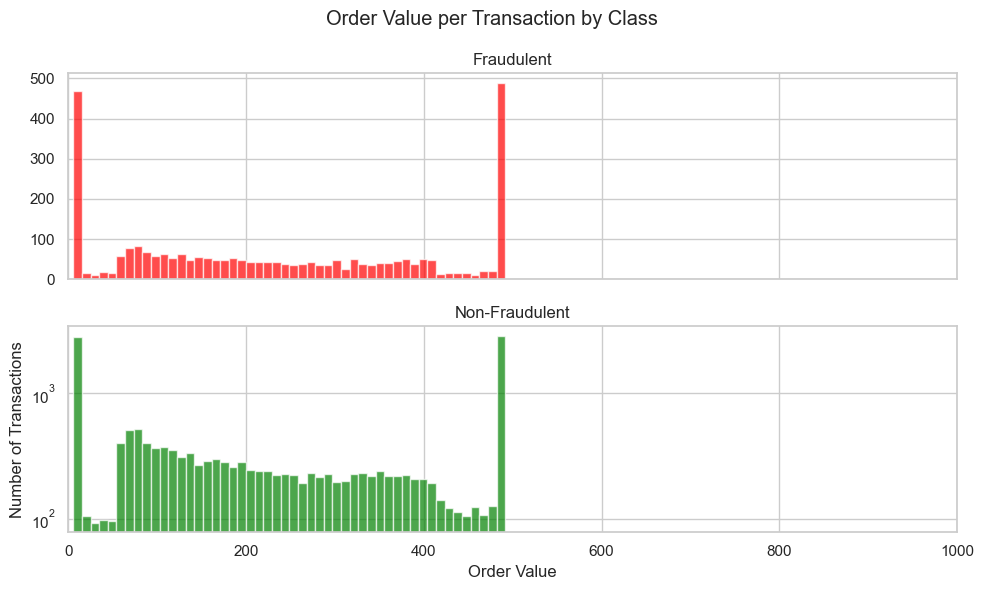

In [19]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,6))
f.suptitle('Order Value per Transaction by Class')

bins = 50

# Fraudulent transactions
ax1.hist(fraud['order_value'], bins=bins, color='red', alpha=0.7)
ax1.set_title('Fraudulent')

# Non-Fraudulent transactions
ax2.hist(not_fraud['order_value'], bins=bins, color='green', alpha=0.7)
ax2.set_title('Non-Fraudulent')

plt.xlabel('Order Value')
plt.ylabel('Number of Transactions')

plt.xlim((0, 1000))   # adjust if your amounts are very large
plt.yscale('log')     # log scale helps with skewed data
plt.tight_layout()
plt.show()

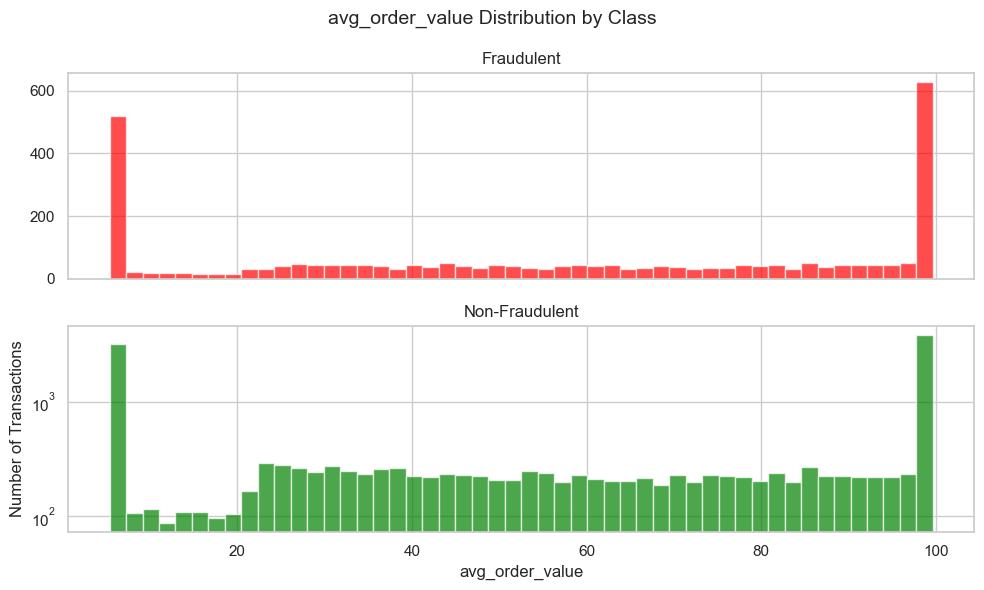

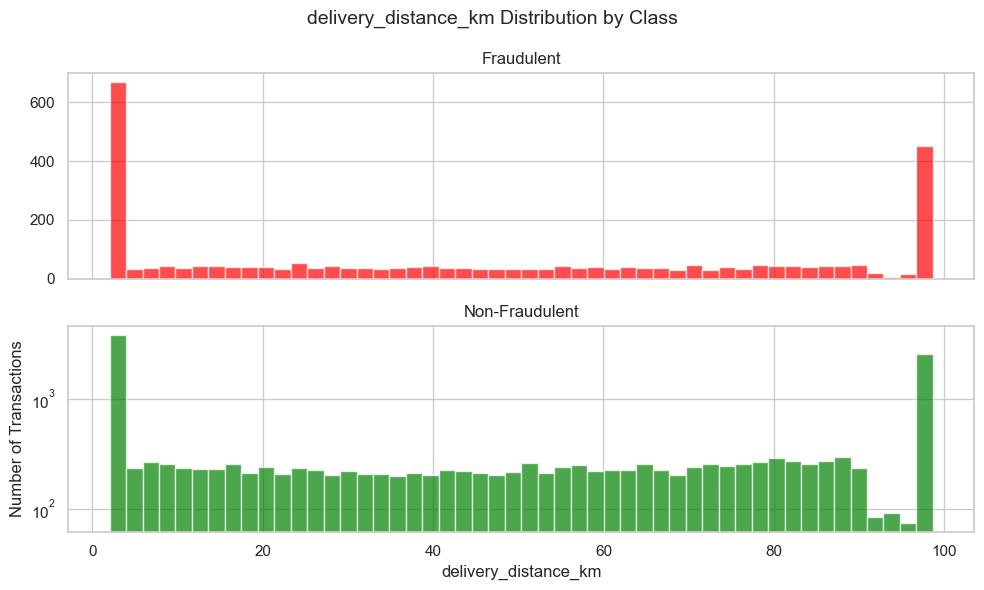

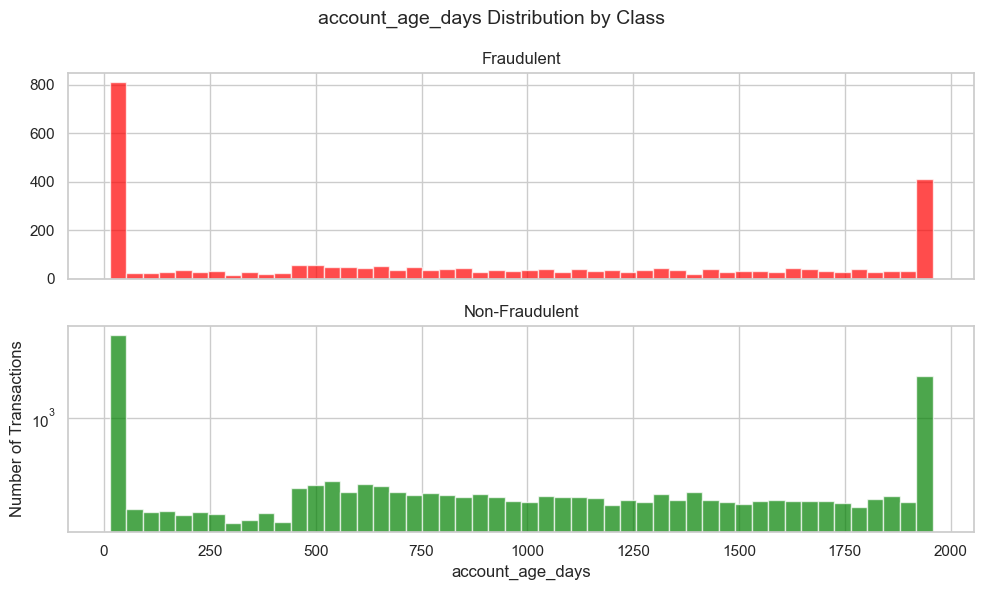

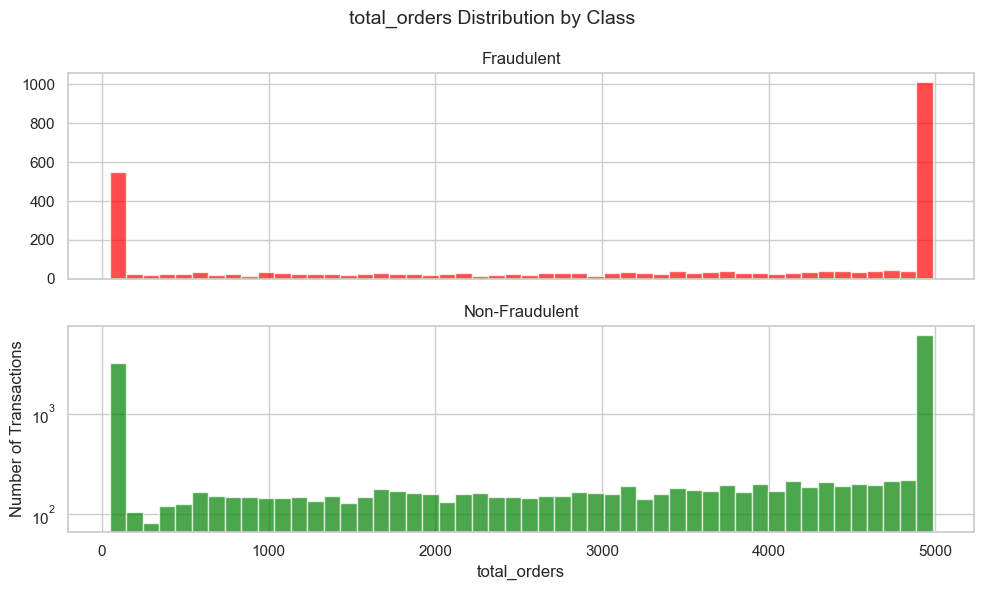

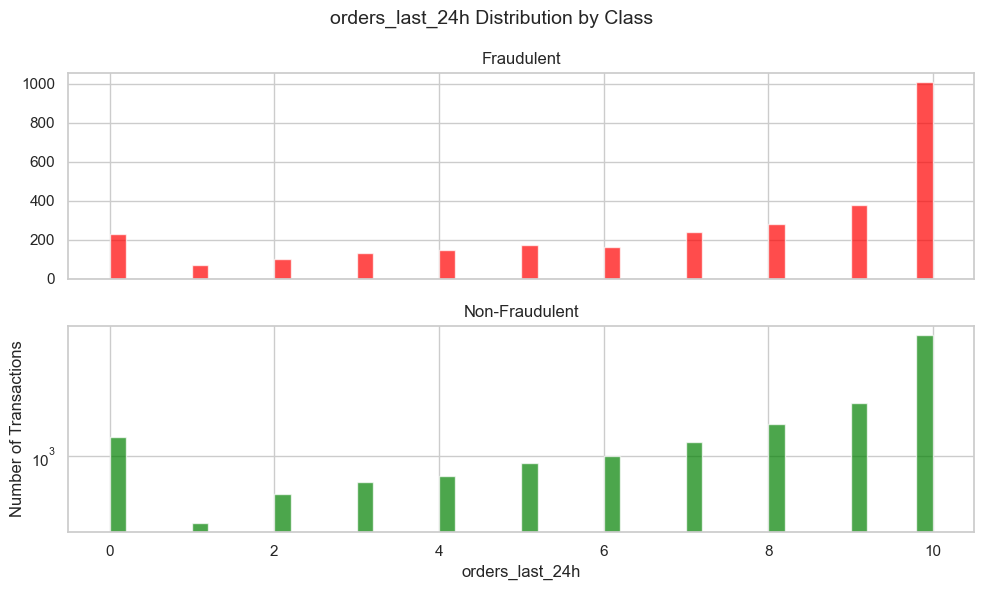

In [20]:
# Comparative Distribution Analysis for Numerical Features

exclude = ['fraudulent', 'order_value']
num_features = [col for col in numerical_features if col not in exclude]

for col in num_features:
    if col == 'fraudulent':  
        continue
    
    f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,6))
    f.suptitle(f'{col} Distribution by Class', fontsize=14)
    
    bins = 50
    
    # Fraudulent transactions
    ax1.hist(fraud[col], bins=bins, color='red', alpha=0.7)
    ax1.set_title('Fraudulent')
    
    # Non-Fraudulent transactions
    ax2.hist(not_fraud[col], bins=bins, color='green', alpha=0.7)
    ax2.set_title('Non-Fraudulent')
    
    plt.xlabel(col)
    plt.ylabel('Number of Transactions')
    
    plt.yscale('log')     
    plt.tight_layout()
    plt.show()

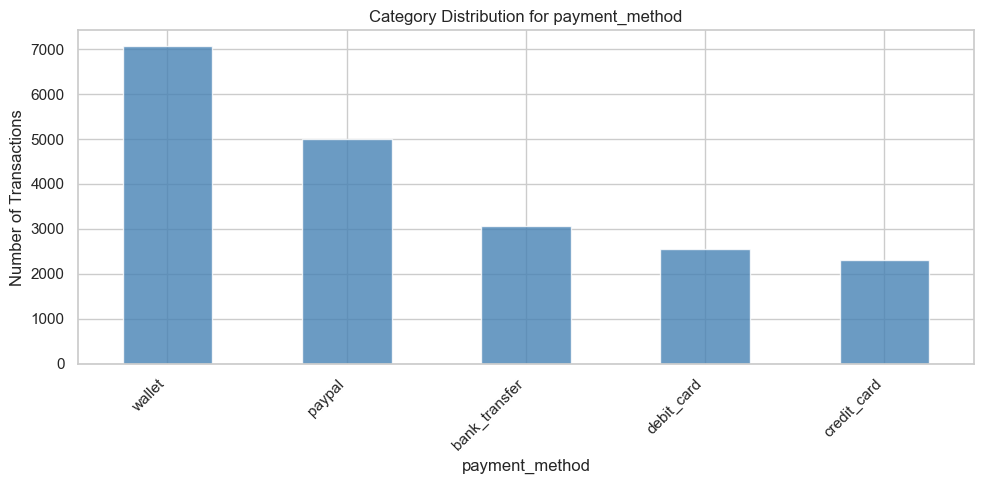

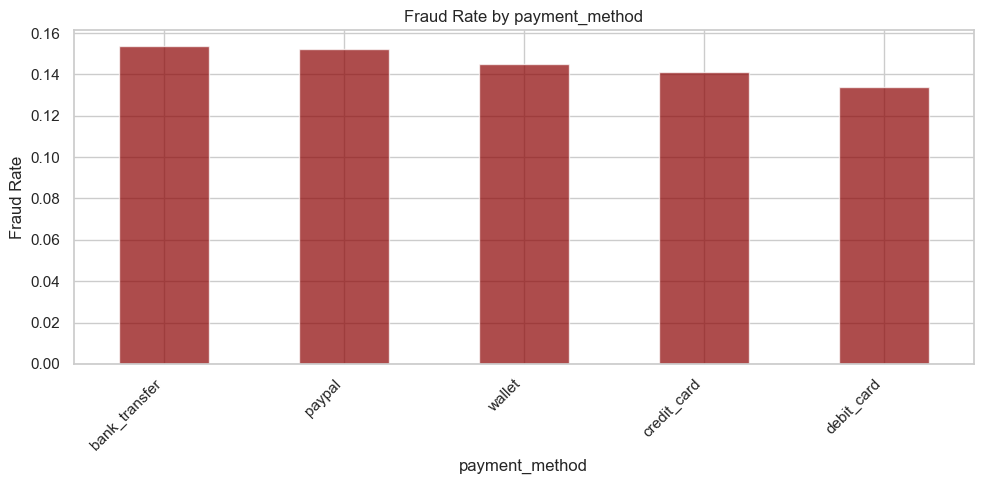

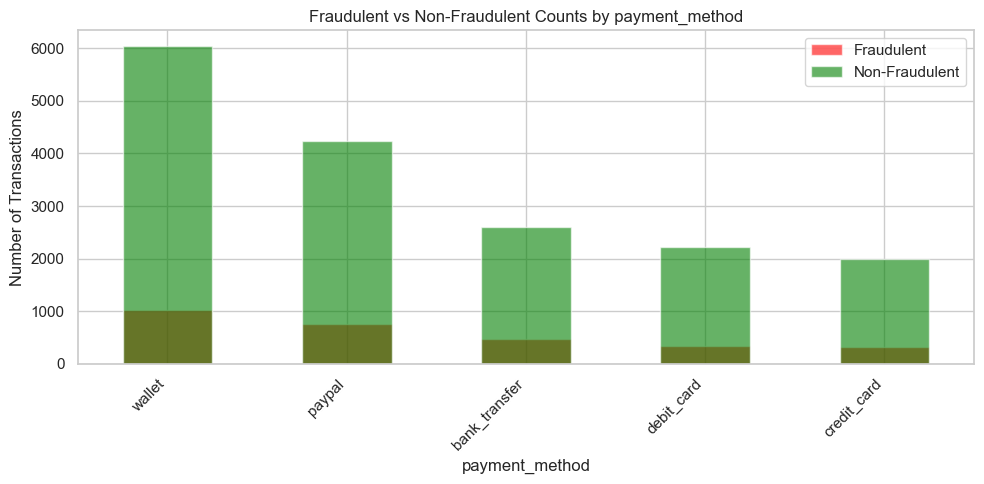

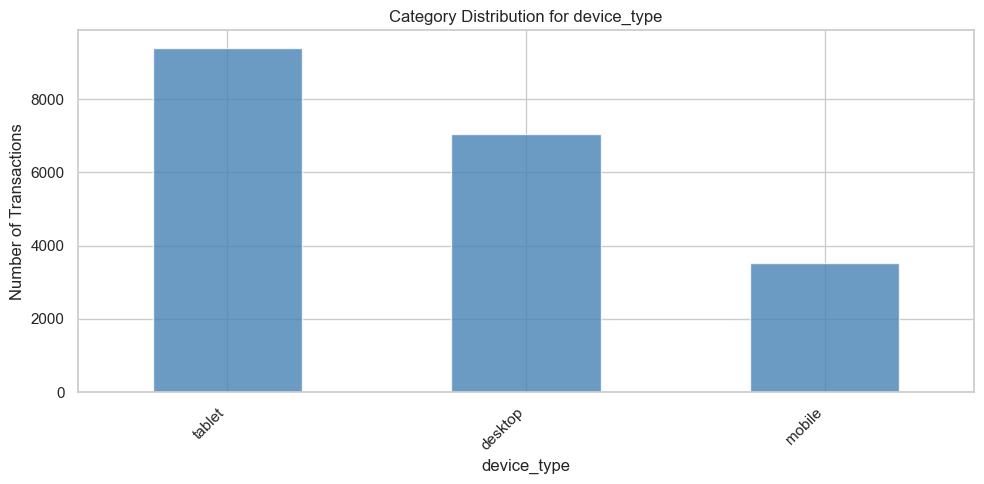

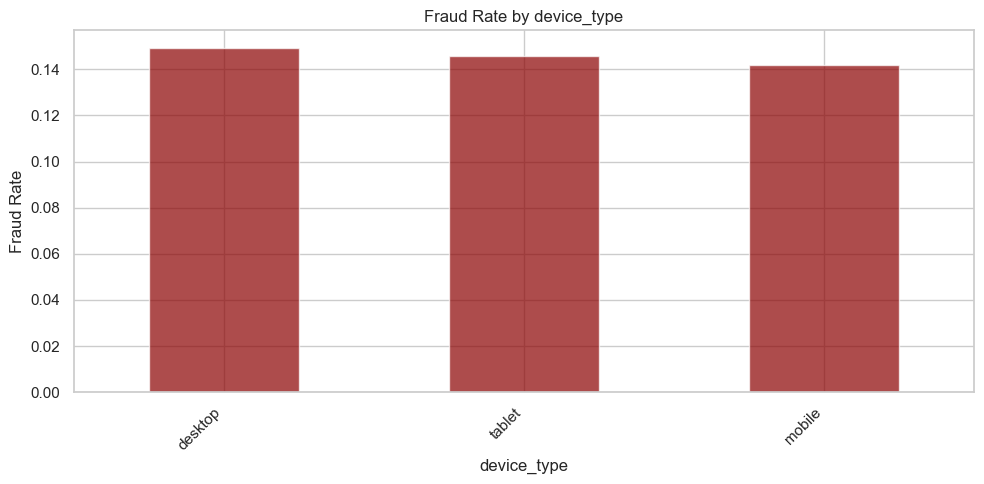

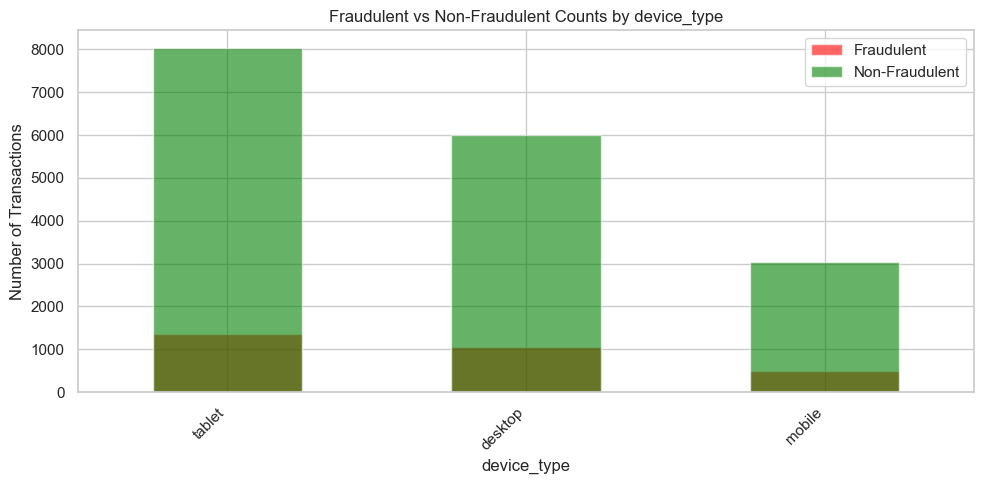

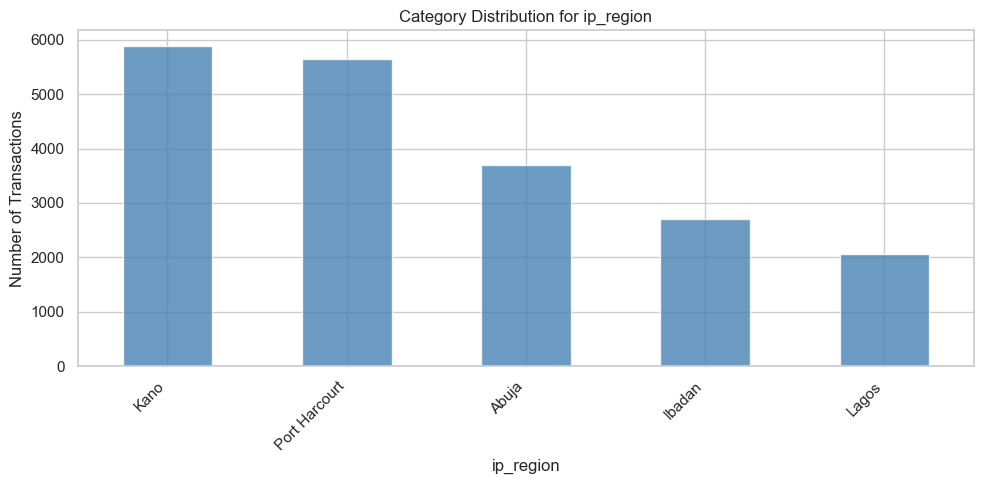

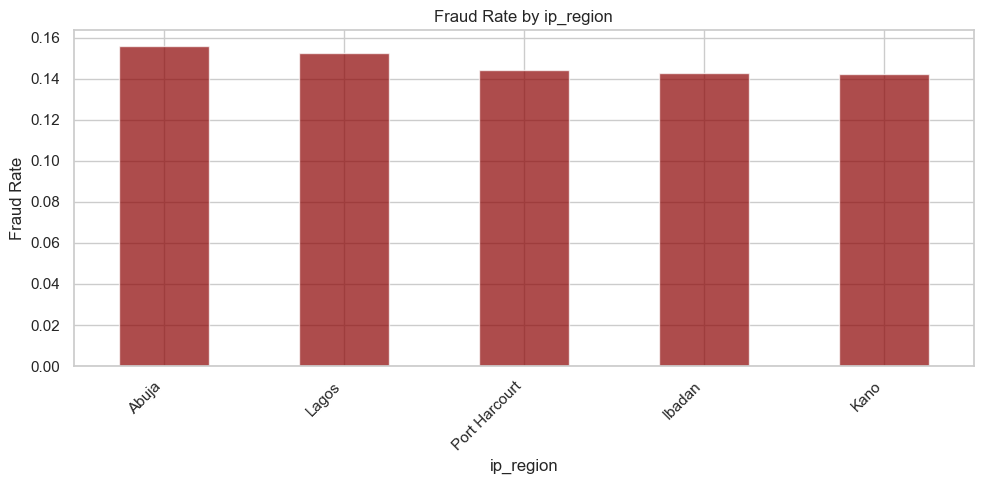

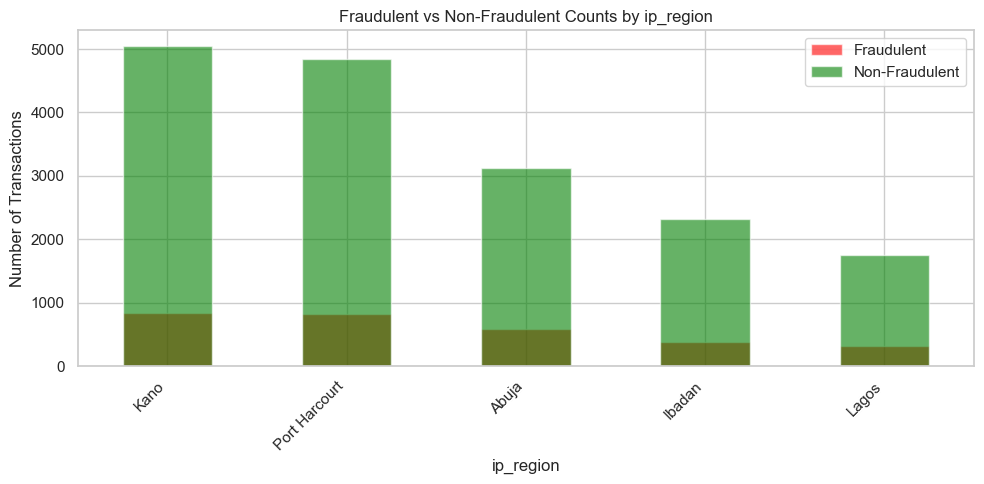

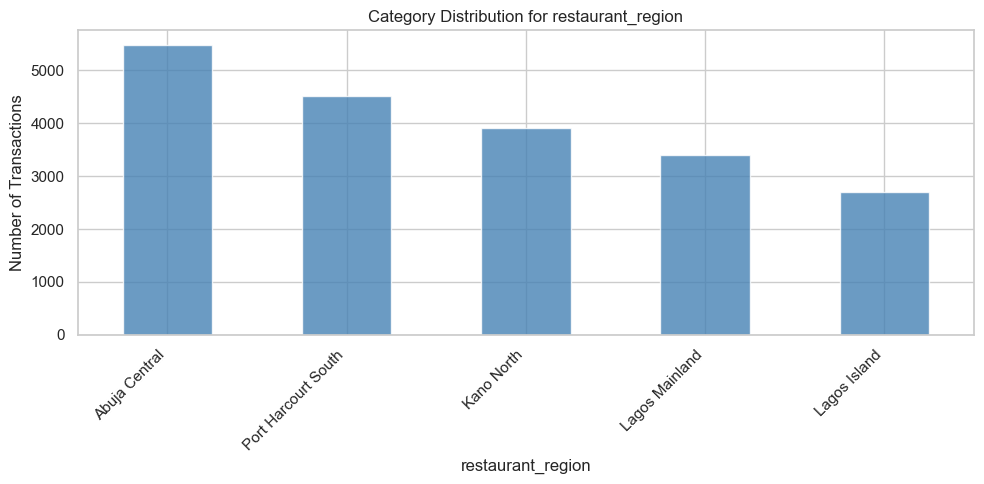

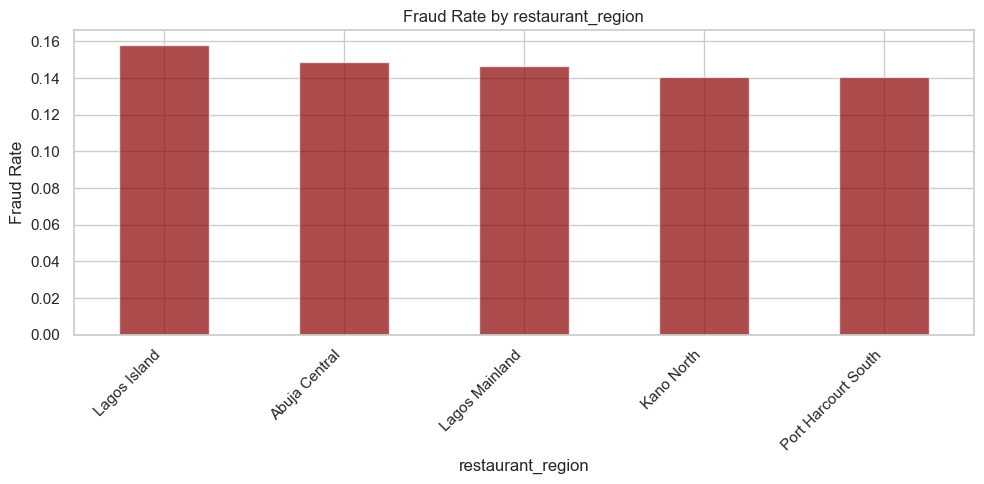

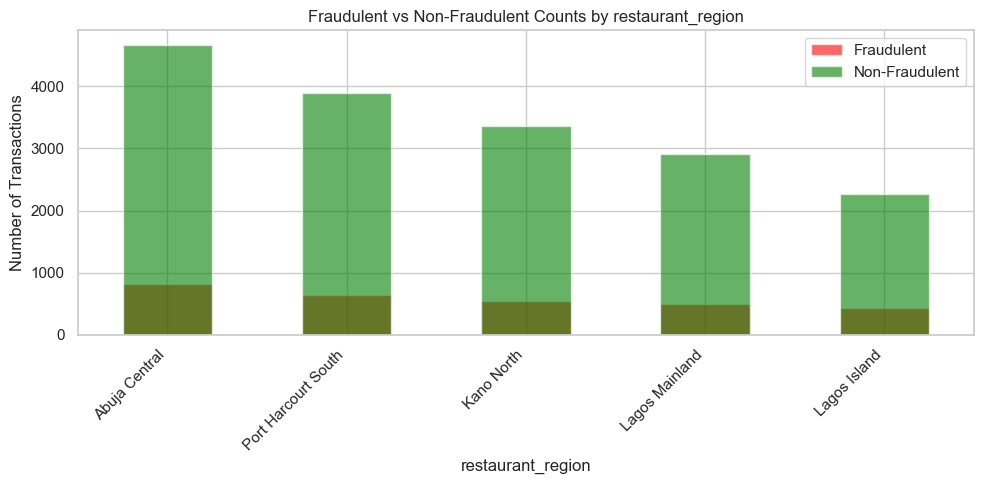

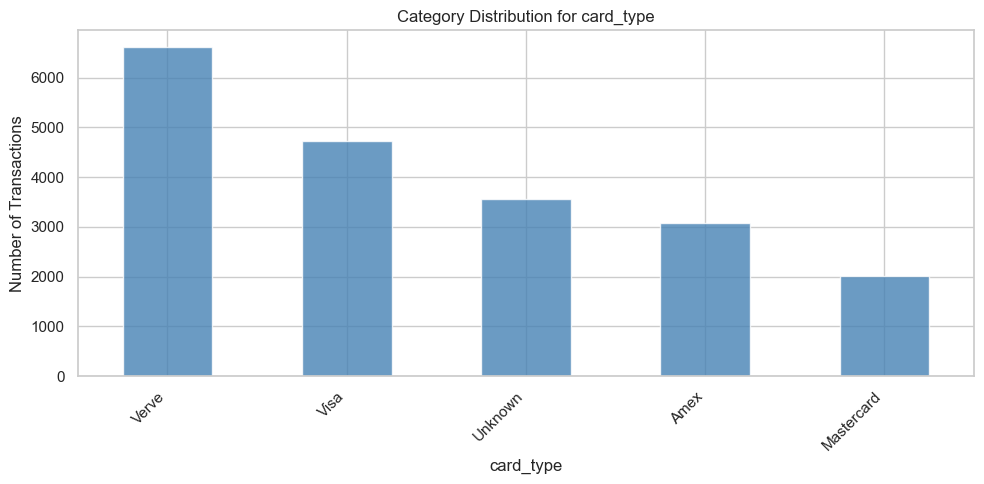

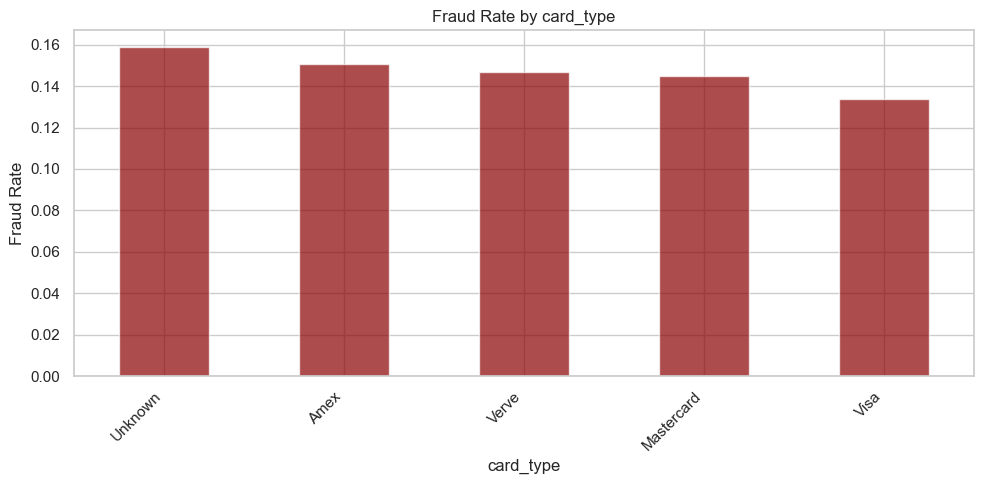

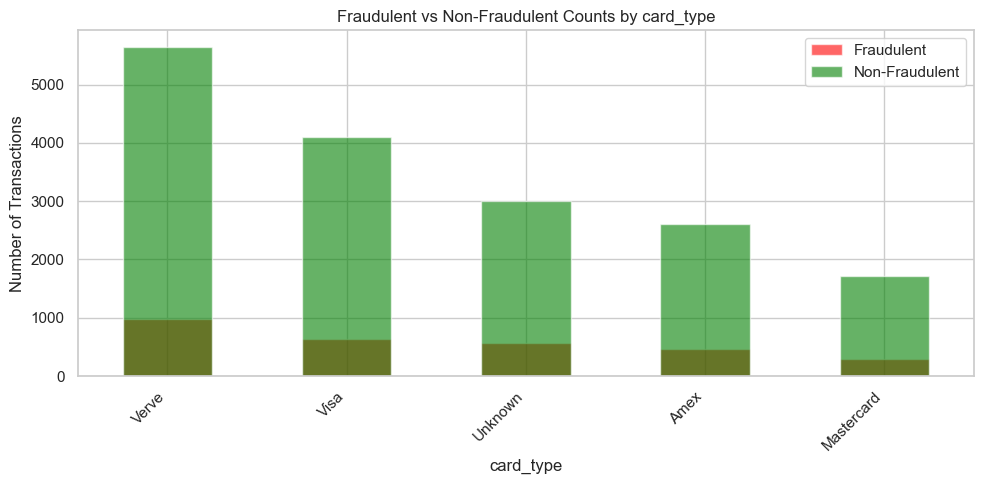

In [21]:
categorical_features = ['payment_method', 'device_type', 'ip_region', 'restaurant_region', 'card_type']

for col in categorical_features:
    # Count of transactions per category (all categories)
    plt.figure(figsize=(10,5))
    counts = df[col].value_counts()
    counts.plot(kind='bar', color="steelblue", alpha=0.8)
    plt.title(f"Category Distribution for {col}")
    plt.ylabel("Number of Transactions")
    plt.xlabel(col)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # Fraud rate by category (all categories)
    plt.figure(figsize=(10,5))
    fr = df.groupby(col)['fraudulent'].mean().sort_values(ascending=False)
    fr.plot(kind='bar', color="darkred", alpha=0.7)
    plt.title(f"Fraud Rate by {col}")
    plt.ylabel("Fraud Rate")
    plt.xlabel(col)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # Fraudulent vs Non-Fraudulent counts (all categories)
    plt.figure(figsize=(10,5))
    fraud_counts = fraud[col].value_counts()
    not_fraud_counts = not_fraud[col].value_counts()

    fraud_counts.plot(kind='bar', color='red', alpha=0.6, label='Fraudulent')
    not_fraud_counts.plot(kind='bar', color='green', alpha=0.6, label='Non-Fraudulent')

    plt.title(f"Fraudulent vs Non-Fraudulent Counts by {col}")
    plt.ylabel("Number of Transactions")
    plt.xlabel(col)
    plt.legend()
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


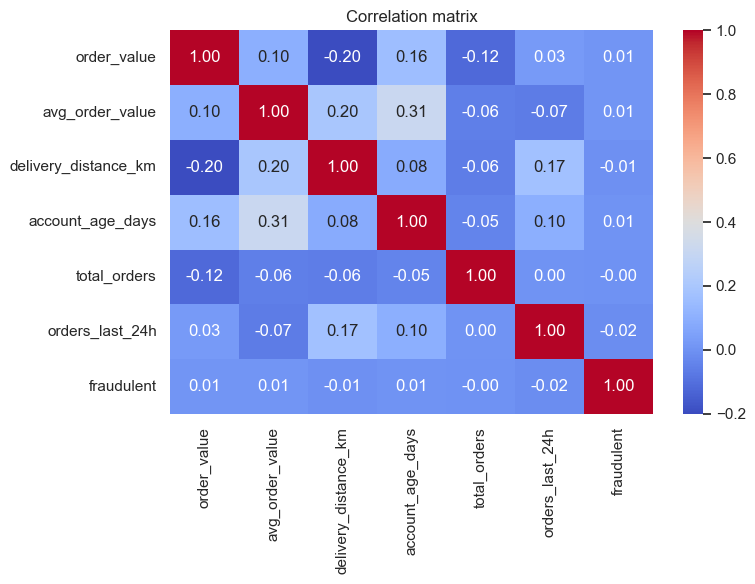

fraudulent              1.000000
avg_order_value         0.008697
order_value             0.007555
account_age_days        0.005212
total_orders           -0.002449
delivery_distance_km   -0.005562
orders_last_24h        -0.017516
Name: fraudulent, dtype: float64


In [22]:
num_df = df[numerical_features + ['fraudulent']].copy()
corr = num_df.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation matrix")
plt.tight_layout()
plt.show()

print(corr['fraudulent'].sort_values(ascending=False))

## Feature Engineering

In [23]:
def create_time_features(df):
    df = df.copy()
    df['order_timestamp'] = pd.to_datetime(df['order_timestamp'])
    df['order_hour'] = df['order_timestamp'].dt.hour
    df['order_day'] = df['order_timestamp'].dt.day
    df['order_month'] = df['order_timestamp'].dt.month
    df['order_day_of_week'] = df['order_timestamp'].dt.dayofweek

    df['is_weekend'] = (df['order_day_of_week'] >= 5).astype(int)
    df['is_night'] = ((df['order_hour'] >= 22) | (df['order_hour'] <= 6)).astype(int)
    df['is_rush_hour'] = ((df['order_hour'] >= 17) & (df['order_hour'] <= 20)).astype(int)
    return df

In [24]:
def create_velocity_features(df):
    df = df.copy()
    df['order_velocity_24h'] = df.get('orders_last_24h', 0).astype(float) / (df.get('total_orders', 0).astype(float) + 1)
    df['avg_daily_orders'] = df.get('total_orders', 0).astype(float) / (df.get('account_age_days', 0).astype(float) + 1)
    df['value_velocity'] = df.get('order_value', 0).astype(float) / (df.get('avg_order_value', 0).astype(float) + 1)
    df['value_deviation'] = (df.get('order_value', 0).astype(float) - df.get('avg_order_value', 0).astype(float)) / (df.get('avg_order_value', 0).astype(float) + 1)
    return df

In [25]:
def create_behavior_features(df):
    df = df.copy()
    df['user_engagement'] = df.get('total_orders', 0).astype(float) / (df.get('account_age_days', 0).astype(float) + 1)
    df['refund_rate'] = df.get('refund_requests', 0).astype(float) / (df.get('total_orders', 0).astype(float) + 1)
    df['promo_usage_rate'] = df.get('promo_code_used', 0).astype(float) / (df.get('total_orders', 0).astype(float) + 1)
    flags = ['past_fraud_flag', 'ip_shared_flag', 'chargeback_flag']
    for f in flags:
        if f not in df.columns:
            df[f] = 0
    df['risk_score'] = (df['past_fraud_flag'] + df['ip_shared_flag'] + df['chargeback_flag']) / 3.0
    return df

In [26]:
def create_geo_device_features(df):
    df = df.copy()
    df['ip_billing_mismatch'] = (df.get('ip_region') != df.get('billing_address_region')).astype(int)
    df['ip_delivery_mismatch'] = (df.get('ip_region') != df.get('delivery_address_region')).astype(int)
    df['billing_delivery_mismatch'] = (df.get('billing_address_region') != df.get('delivery_address_region')).astype(int)
    df['device_os_combo'] = df.get('device_type', '').astype(str) + '_' + df.get('os', '').astype(str)
    return df

In [27]:
def create_interaction_features(df):
    df = df.copy()
    for col in ['high_value_flag', 'ip_shared_flag', 'account_age_days', 'card_type']:
        if col not in df.columns:
            df[col] = 0
    df['high_value_risk'] = df['high_value_flag'].astype(int) * df['risk_score']
    df['high_value_shared_ip'] = df['high_value_flag'].astype(int) * df['ip_shared_flag'].astype(int)
    df['new_user_high_value'] = ((df['account_age_days'].astype(float) < 30) & (df['high_value_flag'].astype(int) == 1)).astype(int)
    df['card_risk_interaction'] = df['card_type'].astype(str) + '_' + df['risk_score'].astype(str)
    return df

In [28]:
def bin_continuous_features(df):
    df = df.copy()
    if 'account_age_days' in df.columns:
        df['account_age_binned'] = pd.cut(df['account_age_days'].fillna(0).astype(float),
                                         bins=[0, 30, 180, 365, 730, 2000],
                                         labels=['new', 'young', 'established', 'mature', 'veteran'])
    if 'total_orders' in df.columns:
        df['total_orders_binned'] = pd.cut(df['total_orders'].fillna(0).astype(float),
                                          bins=[0, 10, 50, 200, 1000, 5000],
                                          labels=['very_low', 'low', 'medium', 'high', 'very_high'])
    if 'delivery_distance_km' in df.columns:
        df['delivery_distance_binned'] = pd.cut(df['delivery_distance_km'].fillna(0).astype(float),
                                               bins=[0, 5, 15, 30, 50, 100],
                                               labels=['very_close', 'close', 'medium', 'far', 'very_far'])
    return df

In [29]:
def apply_log_transforms(df):
    df = df.copy()
    skewed_features = ['order_value', 'avg_order_value', 'delivery_distance_km', 'total_orders']
    for feature in skewed_features:
        if feature in df.columns:
            df[f'log_{feature}'] = np.log1p(df[feature].fillna(0).astype(float))
    return df

In [30]:
# Basic pipeline aggregator (no leakage)
def feature_engineering_pipeline_basic(df):
    df = create_time_features(df)
    df = create_velocity_features(df)
    df = create_behavior_features(df)
    df = create_geo_device_features(df)
    df = create_interaction_features(df)
    df = bin_continuous_features(df)
    df = apply_log_transforms(df)
    return df

In [31]:
df_fe = feature_engineering_pipeline_basic(df.copy())
print("Feature engineering completed. Columns:", len(df_fe.columns))

Feature engineering completed. Columns: 56


In [32]:
check_cols = [c for c in ['order_hour','is_night','order_velocity_24h','risk_score','ip_billing_mismatch','high_value_risk','account_age_binned','log_order_value'] if c in df_fe.columns]
print("Example FE columns present:", check_cols)
df_fe.head(3)

Example FE columns present: ['order_hour', 'is_night', 'order_velocity_24h', 'risk_score', 'ip_billing_mismatch', 'high_value_risk', 'account_age_binned', 'log_order_value']


,transaction_id,user_id,account_age_days,total_orders,avg_order_value,past_fraud_flag,device_type,os,ip_region,billing_address_region,...,high_value_shared_ip,new_user_high_value,card_risk_interaction,account_age_binned,total_orders_binned,delivery_distance_binned,log_order_value,log_avg_order_value,log_delivery_distance_km,log_total_orders
0,TXN_978033343340,USR_73196,1902,4986,58.24,0,tablet,MacOS,Abuja,Abuja,...,1,0,Amex_0.6666666666666666,veteran,very_high,close,4.583844,4.081597,2.754297,8.514590
1,TXN_813582749922,USR_11955,567,926,83.28,1,mobile,MacOS,Lagos,Port Harcourt,...,1,0,Unknown_1.0,mature,high,very_far,4.241471,4.434145,4.601965,6.831954
2,TXN_113318065960,USR_20396,1958,4802,99.65,1,desktop,MacOS,Kano,Ibadan,...,1,0,Amex_1.0,veteran,very_high,very_close,6.199535,4.611649,1.101940,8.476996


In [33]:
engineered_feats = [
    # time-based
    'order_hour','order_day','order_month','order_day_of_week','is_weekend','is_night','is_rush_hour',
    # velocity
    'order_velocity_24h','avg_daily_orders','value_velocity','value_deviation',
    # behavior
    'user_engagement','refund_rate','promo_usage_rate','risk_score',
    # geo/device
    'ip_billing_mismatch','ip_delivery_mismatch','billing_delivery_mismatch','device_os_combo',
    # interaction
    'high_value_risk','high_value_shared_ip','new_user_high_value','card_risk_interaction',
    # bins & logs
    'account_age_binned','total_orders_binned','delivery_distance_binned',
    'log_order_value','log_avg_order_value','log_delivery_distance_km','log_total_orders',
    # original useful numeric columns
    'order_value','avg_order_value','delivery_distance_km','account_age_days','total_orders','orders_last_24h',
    'payment_retries','refund_requests','promo_code_used','ip_shared_flag','chargeback_flag','high_value_flag'
]


In [34]:
FEATURE_USE = [c for c in engineered_feats if c in df_fe.columns]
print("Using features count:", len(FEATURE_USE))
print(FEATURE_USE)

Using features count: 42
['order_hour', 'order_day', 'order_month', 'order_day_of_week', 'is_weekend', 'is_night', 'is_rush_hour', 'order_velocity_24h', 'avg_daily_orders', 'value_velocity', 'value_deviation', 'user_engagement', 'refund_rate', 'promo_usage_rate', 'risk_score', 'ip_billing_mismatch', 'ip_delivery_mismatch', 'billing_delivery_mismatch', 'device_os_combo', 'high_value_risk', 'high_value_shared_ip', 'new_user_high_value', 'card_risk_interaction', 'account_age_binned', 'total_orders_binned', 'delivery_distance_binned', 'log_order_value', 'log_avg_order_value', 'log_delivery_distance_km', 'log_total_orders', 'order_value', 'avg_order_value', 'delivery_distance_km', 'account_age_days', 'total_orders', 'orders_last_24h', 'payment_retries', 'refund_requests', 'promo_code_used', 'ip_shared_flag', 'chargeback_flag', 'high_value_flag']


In [35]:
FEATURE_CATEGORICAL_OHE = []
for c in ['payment_method','device_type','order_day_of_week','account_age_binned','total_orders_binned','delivery_distance_binned','device_os_combo']:
    if c in df_fe.columns:
        FEATURE_CATEGORICAL_OHE.append(c)

print("Categorical OHE features:", FEATURE_CATEGORICAL_OHE)

Categorical OHE features: ['payment_method', 'device_type', 'order_day_of_week', 'account_age_binned', 'total_orders_binned', 'delivery_distance_binned', 'device_os_combo']


In [36]:
# Split early to avoid leakage (train/holdout)

X = df_fe.copy()
if 'fraudulent' not in X.columns:
    raise ValueError("Target column 'fraudulent' not found in dataframe.")
y = X['fraudulent'].astype(int)

In [37]:
X_train_full, X_hold, y_train_full, y_hold = train_test_split(X, y, test_size=0.30, stratify=y, random_state=RANDOM_STATE)

In [38]:
# SAFE target-encoding for high-cardinality features (fit on train only)

high_cardinality_features = [c for c in ['ip_region','restaurant_region','user_id'] if c in X.columns]

def fit_target_encoding_maps(X_train, y_train, high_cardinality_features):
    df_train = X_train.copy()
    df_train['_y_temp_target'] = y_train.values
    encoding_maps = {}
    global_mean = y_train.mean()
    for feature in high_cardinality_features:
        if feature in df_train.columns:
            enc_map = df_train.groupby(feature)['_y_temp_target'].mean().to_dict()
            encoding_maps[feature] = enc_map
    return encoding_maps, global_mean

def apply_target_encoding_maps(X, encoding_maps, global_mean):
    X = X.copy()
    for feature, enc_map in encoding_maps.items():
        if feature in X.columns:
            X[f'{feature}_target_encoded'] = X[feature].map(enc_map).fillna(global_mean)
    return X

In [39]:
# Fit encoders
encoding_maps, global_mean = fit_target_encoding_maps(X_train_full, y_train_full, high_cardinality_features)

In [40]:
# Apply to train & holdout
X_train_full = apply_target_encoding_maps(X_train_full, encoding_maps, global_mean)
X_hold = apply_target_encoding_maps(X_hold, encoding_maps, global_mean)

In [41]:
for f in high_cardinality_features:
    enc_col = f + '_target_encoded'
    if enc_col in X_train_full.columns and enc_col not in FEATURE_USE:
        FEATURE_USE.append(enc_col)

In [42]:
# Assemble feature matrices with OHE + scaling (train-only fit)

def assemble_features(df_slice, ohe_cols, feature_use):
    # One-hot (small-cardinality)
    if len(ohe_cols) > 0:
        ohe = pd.get_dummies(df_slice[ohe_cols].fillna('unknown').astype(str), prefix=ohe_cols)
        base = df_slice[[c for c in feature_use if c not in ohe_cols]].reset_index(drop=True)
        res = pd.concat([base.reset_index(drop=True), ohe.reset_index(drop=True)], axis=1)
    else:
        res = df_slice[feature_use].reset_index(drop=True)
    return res

In [43]:
def assemble_features(df_slice, ohe_cols, feature_use):
    """
    Assemble a feature matrix with:
      - One-hot encoding for categorical features (handles NaNs safely)
      - Pass-through for the rest of the selected features
    """

    # Handle categorical features robustly
    if len(ohe_cols) > 0:
        # Convert to string to avoid category fillna issues
        cat_df = (
            df_slice[ohe_cols]
            .astype("string")              # ensures safe string dtype
            .fillna("unknown")             # replaces missing with 'unknown'
        )
        ohe = pd.get_dummies(cat_df, prefix=ohe_cols)
    else:
        ohe = pd.DataFrame(index=df_slice.index)

    # Keep the non-categorical features in feature_use
    base = df_slice[[c for c in feature_use if c not in ohe_cols]].reset_index(drop=True)

    # Combine base features with encoded categoricals
    res = pd.concat([base, ohe.reset_index(drop=True)], axis=1)

    return res


In [44]:
X_train_base = assemble_features(X_train_full, FEATURE_CATEGORICAL_OHE, FEATURE_USE)
numeric_to_scale = [c for c in ['order_value','avg_order_value','delivery_distance_km','order_velocity_24h','avg_daily_orders','orders_per_month','account_age_days','total_orders'] if c in X_train_base.columns]

In [45]:
# Fill NaNs in numeric columns
for c in numeric_to_scale:
    X_train_base[c] = X_train_base[c].astype(float).fillna(0.0)

scaler = StandardScaler()
if len(numeric_to_scale) > 0:
    X_train_base[numeric_to_scale] = scaler.fit_transform(X_train_base[numeric_to_scale])

X_hold_base = assemble_features(X_hold, FEATURE_CATEGORICAL_OHE, FEATURE_USE)
# align columns
X_train_base, X_hold_base = X_train_base.align(X_hold_base, join='outer', axis=1, fill_value=0)
# scale holdout numeric cols
if len(numeric_to_scale) > 0:
    X_hold_base[numeric_to_scale] = scaler.transform(X_hold_base[numeric_to_scale])

# convert y to reset index
y_train_full = y_train_full.reset_index(drop=True)
y_hold = y_hold.reset_index(drop=True)

print("Train features shape:", X_train_base.shape, "Holdout features shape:", X_hold_base.shape)


Train features shape: (14000, 84) Holdout features shape: (6000, 84)


In [46]:
# Build realistic low-prevalence test set 

desired_prevalence = 0.005  # 0.5%
hold_df = X_hold.copy().reset_index(drop=True)
hold_df['fraudulent'] = y_hold.copy().reset_index(drop=True)

n_hold = len(hold_df)
desired_fraud_count = max(1, int(n_hold * desired_prevalence))

frauds = hold_df[hold_df['fraudulent']==1]
nonfrauds = hold_df[hold_df['fraudulent']==0]

if len(frauds) >= desired_fraud_count:
    fraud_sample = frauds.sample(desired_fraud_count, random_state=RANDOM_STATE)
else:
    fraud_sample = frauds.copy()

nonfraud_needed = min(len(nonfrauds), int(len(fraud_sample) * ((1/desired_prevalence) - 1)))
nonfraud_sample = nonfrauds.sample(nonfraud_needed, random_state=RANDOM_STATE)

test_realistic_df = pd.concat([fraud_sample, nonfraud_sample]).sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
print("Realistic test set shape:", test_realistic_df.shape, "Fraud rate:", test_realistic_df['fraudulent'].mean()*100)

Realistic test set shape: (5152, 59) Fraud rate: 0.5822981366459627


In [47]:
# assemble features for realistic test
X_test_real = assemble_features(test_realistic_df, FEATURE_CATEGORICAL_OHE, FEATURE_USE)
X_test_real = X_test_real.reindex(columns=X_train_base.columns, fill_value=0)
# scale numeric
if len(numeric_to_scale) > 0:
    X_test_real[numeric_to_scale] = scaler.transform(X_test_real[numeric_to_scale])
y_test_real = test_realistic_df['fraudulent'].astype(int).reset_index(drop=True)

# Use training set for model fitting
X_train_final = X_train_base.copy()
y_train_final = y_train_full.copy()

# Modeling and Evaluation

In [48]:
# Modeling / evaluation helpers 

results = {}

def evaluate_and_store(name, model, X_eval, y_eval):
    # handle IsolationForest separately
    if name.startswith("IsolationForest"):
        try:
            scores = -model.decision_function(X_eval)
        except Exception:
            try:
                scores = model.predict_proba(X_eval)[:,1]
            except Exception:
                scores = model.score_samples(X_eval) * -1
        y_prob = (scores - scores.min()) / (scores.max() - scores.min() + 1e-9)
        y_pred = (y_prob >= 0.5).astype(int)
    else:
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_eval)[:,1]
        else:
            y_prob = model.predict(X_eval)
        y_pred = (y_prob >= 0.5).astype(int)

    roc = roc_auc_score(y_eval, y_prob) if len(np.unique(y_eval)) > 1 else np.nan
    pr = average_precision_score(y_eval, y_prob) if len(np.unique(y_eval)) > 1 else np.nan
    report = classification_report(y_eval, y_pred, zero_division=0)
    cm = confusion_matrix(y_eval, y_pred)

    results[name] = {'model': model, 'roc_auc': roc, 'pr_auc': pr, 'y_prob': y_prob, 'y_pred': y_pred, 'report': report, 'cm': cm}
    print(f"== {name} == ROC-AUC: {roc:.4f} | PR-AUC: {pr:.6f}")
    print(report)
    print("Confusion matrix:\n", cm)
    return results[name]

In [49]:
# Drop the problematic column from train and test
X_train_final = X_train_final.drop(columns=['card_risk_interaction'], errors='ignore')
X_test_real   = X_test_real.drop(columns=['card_risk_interaction'], errors='ignore')



In [50]:
#Train classical supervised models (LR, DT, RF, XGBoost)

lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=RANDOM_STATE)
lr.fit(X_train_final, y_train_final)
evaluate_and_store("LogisticRegression_balanced", lr, X_test_real, y_test_real)

dt = DecisionTreeClassifier(max_depth=6, class_weight='balanced', random_state=RANDOM_STATE)
dt.fit(X_train_final, y_train_final)
evaluate_and_store("DecisionTree", dt, X_test_real, y_test_real)

rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1)
rf.fit(X_train_final, y_train_final)
evaluate_and_store("RandomForest", rf, X_test_real, y_test_real)

if XGBOOST_AVAILABLE:
    ratio = (len(y_train_final) - y_train_final.sum()) / (y_train_final.sum() + 1e-9)
    xgb = XGBClassifier(scale_pos_weight=ratio, use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE, n_jobs=-1)
    xgb.fit(X_train_final, y_train_final)
    evaluate_and_store("XGBoost", xgb, X_test_real, y_test_real)
else:
    print("XGBoost not available; skipping.")

== LogisticRegression_balanced == ROC-AUC: 0.4665 | PR-AUC: 0.008068
              precision    recall  f1-score   support

           0       0.99      0.56      0.72      5122
           1       0.01      0.40      0.01        30

    accuracy                           0.56      5152
   macro avg       0.50      0.48      0.36      5152
weighted avg       0.99      0.56      0.71      5152

Confusion matrix:
 [[2864 2258]
 [  18   12]]
== DecisionTree == ROC-AUC: 0.4225 | PR-AUC: 0.005074
              precision    recall  f1-score   support

           0       0.99      0.45      0.62      5122
           1       0.00      0.40      0.01        30

    accuracy                           0.45      5152
   macro avg       0.50      0.43      0.32      5152
weighted avg       0.99      0.45      0.62      5152

Confusion matrix:
 [[2323 2799]
 [  18   12]]
== RandomForest == ROC-AUC: 0.4690 | PR-AUC: 0.006265
              precision    recall  f1-score   support

           0       0.9

In [51]:
# Unsupervised: IsolationForest on non-fraud part of train
# ----------------------
train_nonfraud = X_train_final[y_train_final==0]
iso = IsolationForest(n_estimators=200, contamination='auto', random_state=RANDOM_STATE)
iso.fit(train_nonfraud)
evaluate_and_store("IsolationForest_on_nonfraud", iso, X_test_real, y_test_real)

== IsolationForest_on_nonfraud == ROC-AUC: 0.5515 | PR-AUC: 0.023476
              precision    recall  f1-score   support

           0       0.99      0.75      0.85      5122
           1       0.01      0.27      0.01        30

    accuracy                           0.74      5152
   macro avg       0.50      0.51      0.43      5152
weighted avg       0.99      0.74      0.85      5152

Confusion matrix:
 [[3828 1294]
 [  22    8]]


{'model': IsolationForest(n_estimators=200, random_state=42),
 'roc_auc': 0.5514837953924248,
 'pr_auc': 0.023476025480307045,
 'y_prob': array([0.31188882, 0.69781706, 0.40907667, ..., 0.45915624, 0.61910943,
        0.42566493], shape=(5152,)),
 'y_pred': array([0, 1, 0, ..., 0, 1, 0], shape=(5152,)),
 'report': '              precision    recall  f1-score   support\n\n           0       0.99      0.75      0.85      5122\n           1       0.01      0.27      0.01        30\n\n    accuracy                           0.74      5152\n   macro avg       0.50      0.51      0.43      5152\nweighted avg       0.99      0.74      0.85      5152\n',
 'cm': array([[3828, 1294],
        [  22,    8]])}

In [52]:
# Keep only numeric features
X_train_numeric = X_train_final.select_dtypes(include=['int64', 'float64'])
X_test_numeric = X_test_real.select_dtypes(include=['int64', 'float64'])

#Resampling: SMOTE + RF
sm = SMOTE(random_state=RANDOM_STATE)

rf_sm = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
pipeline_sm = ImbPipeline([('smote', sm), ('rf', rf_sm)])
pipeline_sm.fit(X_train_numeric, y_train_final)
evaluate_and_store("RandomForest_with_SMOTE", pipeline_sm, X_test_numeric, y_test_real)


== RandomForest_with_SMOTE == ROC-AUC: 0.4760 | PR-AUC: 0.006400
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      5122
           1       0.00      0.00      0.00        30

    accuracy                           0.99      5152
   macro avg       0.50      0.50      0.50      5152
weighted avg       0.99      0.99      0.99      5152

Confusion matrix:
 [[5101   21]
 [  30    0]]


{'model': Pipeline(steps=[('smote', SMOTE(random_state=42)),
                 ('rf',
                  RandomForestClassifier(n_estimators=200, n_jobs=-1,
                                         random_state=42))]),
 'roc_auc': 0.4759566575556423,
 'pr_auc': 0.006399989860534502,
 'y_prob': array([0.11 , 0.175, 0.36 , ..., 0.14 , 0.23 , 0.125], shape=(5152,)),
 'y_pred': array([0, 0, 0, ..., 0, 0, 0], shape=(5152,)),
 'report': '              precision    recall  f1-score   support\n\n           0       0.99      1.00      1.00      5122\n           1       0.00      0.00      0.00        30\n\n    accuracy                           0.99      5152\n   macro avg       0.50      0.50      0.50      5152\nweighted avg       0.99      0.99      0.99      5152\n',
 'cm': array([[5101,   21],
        [  30,    0]])}

In [54]:
# Summary table
summary = []
for name, res in results.items():
    summary.append({'model': name, 'roc_auc': res['roc_auc'], 'pr_auc': res['pr_auc']})
summary_df = pd.DataFrame(summary).sort_values(by='pr_auc', ascending=False).reset_index(drop=True)
print("Model ranking by PR-AUC:")
display(summary_df)

Model ranking by PR-AUC:


,model,roc_auc,pr_auc
0,IsolationForest_on_nonfraud,0.551484,0.023476
1,LogisticRegression_balanced,0.466537,0.008068
2,RandomForest_with_SMOTE,0.475957,0.006400
3,RandomForest,0.469016,0.006265
4,XGBoost,0.473962,0.005490
5,DecisionTree,0.422481,0.005074


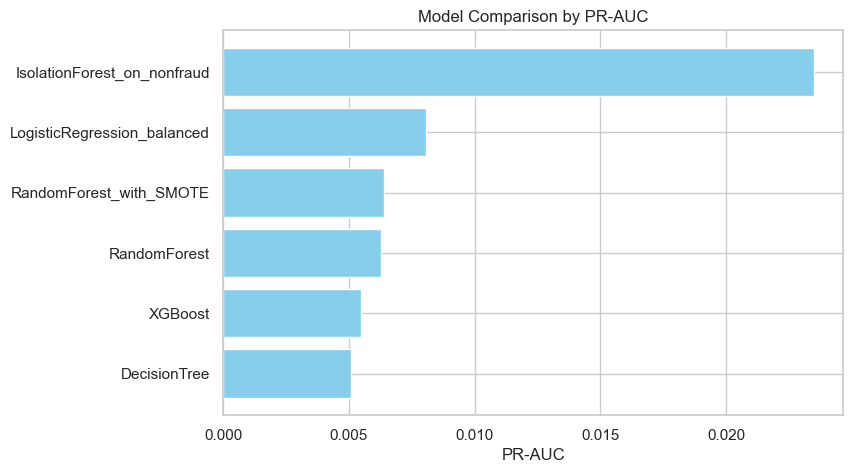

In [55]:
# Plot PR-AUC
plt.figure(figsize=(8,5))
plt.barh(summary_df["model"], summary_df["pr_auc"], color="skyblue")
plt.xlabel("PR-AUC")
plt.title("Model Comparison by PR-AUC")
plt.gca().invert_yaxis()  # highest at top
plt.show()

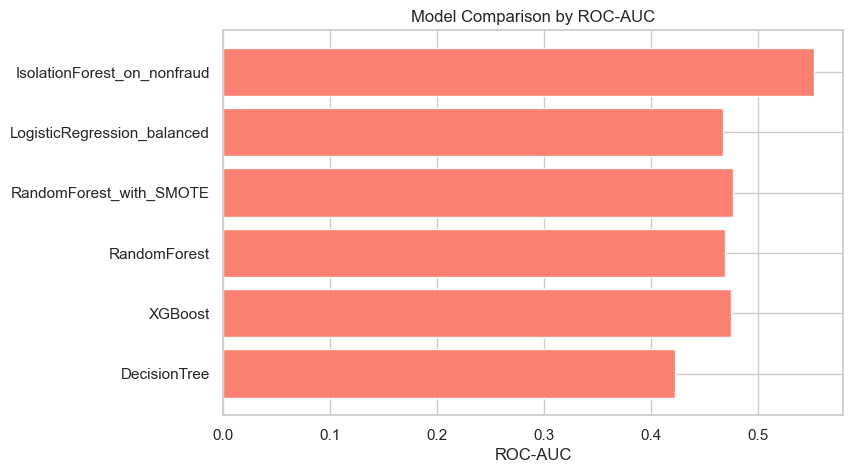

In [56]:
# Plot ROC-AUC
plt.figure(figsize=(8,5))
plt.barh(summary_df["model"], summary_df["roc_auc"], color="salmon")
plt.xlabel("ROC-AUC")
plt.title("Model Comparison by ROC-AUC")
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# Keep only numeric features
X_train_numeric = X_train_final.select_dtypes(include=['int64', 'float64'])
X_test_numeric = X_test_real.select_dtypes(include=['int64', 'float64'])

#Resampling: SMOTE + RF
sm = SMOTE(random_state=RANDOM_STATE)

rf_sm = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
pipeline_sm = ImbPipeline([('smote', sm), ('rf', rf_sm)])
pipeline_sm.fit(X_train_numeric, y_train_final)
evaluate_and_store("RandomForest_with_SMOTE", pipeline_sm, X_test_numeric, y_test_real)


== RandomForest_with_SMOTE == ROC-AUC: 0.4760 | PR-AUC: 0.006400
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      5122
           1       0.00      0.00      0.00        30

    accuracy                           0.99      5152
   macro avg       0.50      0.50      0.50      5152
weighted avg       0.99      0.99      0.99      5152

Confusion matrix:
 [[5101   21]
 [  30    0]]


{'model': Pipeline(steps=[('smote', SMOTE(random_state=42)),
                 ('rf',
                  RandomForestClassifier(n_estimators=200, n_jobs=-1,
                                         random_state=42))]),
 'roc_auc': 0.4759566575556423,
 'pr_auc': 0.006399989860534502,
 'y_prob': array([0.11 , 0.175, 0.36 , ..., 0.14 , 0.23 , 0.125], shape=(5152,)),
 'y_pred': array([0, 0, 0, ..., 0, 0, 0], shape=(5152,)),
 'report': '              precision    recall  f1-score   support\n\n           0       0.99      1.00      1.00      5122\n           1       0.00      0.00      0.00        30\n\n    accuracy                           0.99      5152\n   macro avg       0.50      0.50      0.50      5152\nweighted avg       0.99      0.99      0.99      5152\n',
 'cm': array([[5101,   21],
        [  30,    0]])}